## Imports
---

In [74]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, wavetrend3d, atr, pivotPoints, choch, find_extrema, vwma
from src.backtesting_lib import evaluatePairs, format_data
import pandas_ta as ta
from scipy.signal import argrelextrema
import csv
import plotly.graph_objects as go
import plotly.express as px
import numba
from numba import jit

## Getting the Data
---

# Kleines Tutorial für Backtesting.py

Es besteht aus einen init part wo alle variablen definiert und initialisiert werden und einen next part wo der algorithmus nach und nach jede candle durchgeht. Dabei kann man die zurzeitige Candle mit __self.data.Close[-1]__ abrufen. Dir davor mit -2 usw. Ihr könnt außerdem dabei zwischen Close, Open, High, Low entscheiden. 

Um die zurzeitige Balance zu bekommen ruft ihr self.equity auf. 

Um Indicatoren hinzuzufügen habt ihr folgende Syntax:

__self.IndicatorName = self.I(Indicator, Parameter1, Parameter2, ...)__

Dabei könnt ihr die jetzigen Werte abrufen wie mit den Daten [-n],  $n \in \mathbb{N}$ .

Um Trades einzugehen bentzt man entweder:

__self.buy(size=deineGroesse)__ 

__self.sell(size=deineGroesse)__

Ihr müsst dabei geachten das man entweder die Share anzahl als Integer übergebt oder die eine Kommazahl von $[0,1)$ die darstellt wie viel Prozent deines Portfolios du reinsetzt hast.

um eine Position zu schließen benutzt ihr: 

__self.position.close()__

Das sind so die wichtigsten Befehle. Leider lässt die libary nicht mehrere Positionen gleichzeitig. Falls ihr das umbedingt braucht kann ich nach einer anderen Libary ausschau halten. 

Falls ihr irgendwelche anderen Befehle braucht wie z.B. eine LimitOrder oder sowas dann findet ihr die unter den Documentations: 

- https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#gsc.tab=0


## The Strategy
---

In [89]:
von = 1100
bis = 1300

auxusd = format_data("AUXUSD")

left_cand = 40
right_cand = 3

fig = go.Figure(data=[go.Candlestick(x=auxusd[von:bis].index,
                open=auxusd['Open'][von:bis],
                high=auxusd['High'][von:bis],
                low=auxusd['Low'][von:bis],
                close=auxusd['Close'][von:bis])])
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["higher_high"][von:bis], mode="markers", marker=dict(color="blue", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["lower_low"][von:bis], mode="markers", marker=dict(color="pink", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["higher_low"][von:bis], mode="markers", marker=dict(color="orange", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=find_extrema(auxusd, left_cand, right_cand)["lower_high"][von:bis], mode="markers", marker=dict(color="brown", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=np.where(choch(auxusd, 20, 3) == 0, np.nan, choch(auxusd, 20, 3))[von:bis], mode="markers", marker=dict(color="black", size=8))
fig.add_scatter(x=auxusd[von:bis].index, y=np.where(choch(auxusd, 20, 3, "3T", 1) == 0, np.nan, choch(auxusd, 20, 3, "3T", 1))[von:bis], mode="markers", marker=dict(color="darkgreen", size=8))
fig.update_layout(xaxis_rangeslider_visible=False, width=800)
fig.show()

# ChoCh Strat mit VWAP
---

In [76]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import warnings

warnings.filterwarnings("ignore")

class chocho(Strategy):
    shorts = True
    longs = True
    tradehourStart = 1 #UTC Time
    tradehourEnd = 20 #UTC Time
    timebetween = True
    donttrade = 10
    donttrade2 = 11-1
    timeframeChoch = "3T"
    chochLeft = 40
    chochRight = 3
    stoplosscandles = 8
    atr_window = 14
    uuvwap = False # Macht nur trades wenn der Kurs über dem VWAP ist (oder unter)
    uu1vwap = True # Für die 1. Deviation als range für trade entry
    supertrendlookback = 10
    supertrendmultiplier = 3
    vwmaoff = True
    vwmaLength = 60
    taggedduration = 7
    vwmaduration = 2
    atr_threshold = 0
    close22 = False

    def init(self):
        self.sholong = 0
        self.lastdiffs = []
        self.stoploss = 0
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.taggedshort = False
        self.taggedlong = False
        self.taggedcountershort = 0 # How long a tag is valid to enter with chocho
        self.taggedcounterlong = 0 
        self.fees = 0
        self.entryal = False
        self.index = 0
        self.vwmacounter = 0
        self.length = len(self.data.df)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.vwma = self.I(vwma, self.data.Close, self.data.Volume, self.vwmaLength)
        self.chochLong = self.I(choch, self.data.df, self.chochLeft, self.chochRight, self.timeframeChoch, 1)
        self.chochShort = self.I(choch, self.data.df, self.chochLeft, self.chochRight, self.timeframeChoch, 0)
        self.supertrendu = self.I(supertrend, self.data.df, self.supertrendlookback, self.supertrendmultiplier, 0)
        self.supertrendl = self.I(supertrend, self.data.df, self.supertrendlookback, self.supertrendmultiplier, 1)
        self.atr = self.I(atr, self.data.df, self.atr_window)

        
    def next(self):
        if self.data.index[-1].hour >= self.tradehourStart and self.data.index[-1].hour <= self.tradehourEnd and (self.data.index[-1].hour < self.donttrade or self.data.index[-1].hour > self.donttrade2 or not self.timebetween) and not self.position:
            if self.shorts:
                if not self.taggedshort:
                    if ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                        self.taggedshort = True
                elif (self.chochShort[-1] > 0 and self.atr[-1] > self.atr_threshold and self.taggedshort and self.taggedcountershort < self.taggedduration and (self.data.Close[-1] > self.vwap[-1] or not self.uuvwap) and (self.data.Close[-1] > self.vwapl1[-1] or not self.uu1vwap)) or self.entryal:
                    self.entryal = True
                    if (self.data.Low[-1] < self.vwma[-1] and self.data.High[-1] > self.vwma[-1] and self.vwmacounter < self.vwmaduration) or self.vwmaoff:
                        self.stoploss = 0
                        for i in range(1, self.stoplosscandles):
                            if self.data.High[-i] > self.stoploss:
                                self.stoploss = self.data.High[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = abs(stoploss - entry)
                            if(diff < 0.0000001):
                                diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                            self.lastdiffs.append(diff)
                            size = abs((kapital/100) / abs(diff))
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        self.sell(size=sizeO, sl=self.stoploss)
                        self.sholong = 1
                        self.entryal = False
                    elif self.vwmacounter >= self.vwmaduration:
                        self.entryal = False
                        self.vwmacounter = 0
                    else:
                        self.vwmacounter += 1
                if self.taggedshort:
                    self.taggedcountershort += 1
                if self.taggedcountershort > self.taggedduration:
                    self.taggedshort = False    
                    self.taggedcountershort = 0
            if self.longs and not self.position:
                if not self.taggedlong:
                    if((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                        self.taggedlong = True
                if (self.chochLong[-1] > 0 and self.atr[-1] > self.atr_threshold and self.taggedlong and self.taggedcounterlong < self.taggedduration and (self.data.Close[-1] < self.vwap[-1] or not self.uuvwap) and (self.data.Close[-1] < self.vwapu1[-1] or not self.uu1vwap)) or self.entryal:
                    self.entryal = True
                    if (self.data.Low[-1] < self.vwma[-1] and self.data.High[-1] > self.vwma[-1] and self.vwmacounter < self.vwmaduration) or self.vwmaoff:
                        self.stoploss = 10000000
                        for i in range(1, self.stoplosscandles):
                            if self.data.Low[-i] < self.stoploss:
                                self.stoploss = self.data.Low[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = abs(stoploss - entry)
                            if(diff < 0.0000001):
                                diff = abs(sum(self.lastdiffs) / len(self.lastdiffs))
                            self.lastdiffs.append(diff)
                            size = abs((kapital/100) / abs(diff))
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        self.buy(size=sizeO, sl=self.stoploss)
                        self.sholong = 0
                        self.entryal = False
                    elif self.vwmacounter >= self.vwmaduration:
                        self.entryal = False
                        self.vwmacounter = 0
                    else:
                        self.vwmacounter += 1
                if self.taggedlong:
                    self.taggedcounterlong += 1
                if self.taggedcounterlong > self.taggedduration:
                    self.taggedlong = False
                    self.taggedcounterlong = 0
        elif self.position:
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0):
                    self.position.close()
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0):
                    self.position.close()
                    self.tagged = False
            if self.data.index[-1].hour >= 22 and self.close22:
                self.position.close()
                self.tagged = False

data = format_data("EURUSD", "3T")

bt = Backtest(data, chocho, cash=10000, commission=0.000045, margin=0.01)
stats = bt.run()
stats

Start                     2013-06-05 00:00:00
End                       2023-06-03 12:30:00
Duration                   3650 days 12:30:00
Exposure Time [%]                   10.606816
Equity Final [$]              15600281.185438
Equity Peak [$]               26899680.674911
Return [%]                      155902.811854
Buy & Hold Return [%]              -18.053082
Return (Ann.) [%]                   79.175913
Volatility (Ann.) [%]               84.257825
Sharpe Ratio                         0.939686
Sortino Ratio                        4.484698
Calmar Ratio                          1.66944
Max. Drawdown [%]                  -47.426618
Avg. Drawdown [%]                   -2.524337
Max. Drawdown Duration      542 days 14:45:00
Avg. Drawdown Duration        4 days 11:02:00
# Trades                                 3311
Win Rate [%]                        33.796436
Best Trade [%]                       1.992819
Worst Trade [%]                     -0.448017
Avg. Trade [%]                    

In [56]:
bt.plot()

GridPlot(id='p25256', ...)

# Parameter Optimization
---

In [21]:

data = format_data("EURUSD_NEW", "3T")

bt = Backtest(data[-300000:], chocho, cash=10000, commission=0.00003, margin=0.01)
output = bt.run()

stats, heatmap = bt.optimize(
    supertrendlookback = range(5, 50, 5),
    supertrendmultiplier = range(3, 10, 1),
    maximize='Sharpe Ratio',
    max_tries=100,
    return_heatmap=True,
    random_state=0,
)

  0%|          | 0/9 [00:00<?, ?it/s]

## Get 3 best results

In [22]:
hm = heatmap.groupby(['supertrendlookback', 'supertrendmultiplier']).mean().unstack()
hm

supertrendmultiplier,3,4,5,6,7,8,9
supertrendlookback,,,,,,,
5,0.836969,0.678191,0.684957,0.609006,0.557299,0.503005,0.493292
10,0.788958,0.644672,0.629972,0.592490,0.586635,0.505742,0.484275
15,0.737339,0.744488,0.639240,0.632230,0.575008,0.496799,0.492079
20,0.824825,0.681352,0.671846,0.665572,0.581284,0.493236,0.487539
25,0.814328,0.674816,0.640140,0.686844,0.601770,0.484404,0.477160
30,0.836619,0.709171,0.656915,0.699533,0.609194,0.495119,0.479465
35,0.895104,0.723904,0.725330,0.708781,0.615649,0.505119,0.491248
40,0.904084,0.727550,0.728334,0.703313,0.566397,0.510280,0.506722
45,0.858057,0.796447,0.743918,0.719028,0.570573,0.512961,0.500562


<Axes: xlabel='supertrendmultiplier', ylabel='supertrendlookback'>

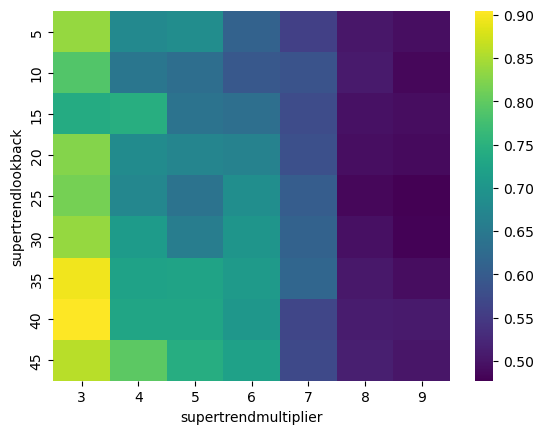

In [23]:
%matplotlib inline

sns.heatmap(hm[::1], cmap='viridis')

# Backtesting multiple pairs at the same time
---

In [3]:
pairsList = ["AUDCAD", "AUDCHF", "AUDJPY", "AUDNZD", "AUDUSD", "CADCHF", "CADJPY", "CHFJPY", "EURAUD", "EURCAD", "EURCHF", "EURGBP", "EURJPY", "EURNZD", "EURUSD", "GBPAUD", "GBPCAD", "GBPCHF", "GBPJPY", "GBPNZD", "GBPUSD", "NZDCAD", "NZDCHF", "NZDJPY", "NZDUSD", "USDCAD", "USDCHF", "USDJPY"]
 
evaluatePairs(pairsList, chocho)

Averaged Equity Final: 3148.4237108396237
Averaged Max. Drawdown: -81.64838089842375
Averaged Avg. Drawdown: -4.949247805956857
Averaged Win Rate: 30.094071364538912
Averaged Best Trade: 4.528936152371455
Averaged Worst Trade: -1.3377820262690956
Averaged Avg. Trade: -0.007848388823037242
Averaged Expectancy: -0.007621849468080683
Averaged Sharpe Ratio: 0.011702641408606773
Averaged Sortino Ratio: 0.03261648052207114
Averaged Calmar Ratio: 0.008271991824048445
Averaged Exposure: 18.000540617702526
Averaged Profit Factor: 0.8811697709940413
Total number of Trades: 133689
